In [1]:
import networkx as nx
from rdkit import Chem

In [2]:
import sys
sys.path.append('../')

# smiles to graph

In [3]:
from src.transform_graph import smiles_to_graph, graph_to_smiles

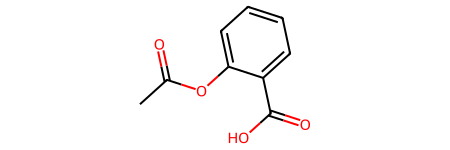

In [4]:
# example - 1
smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
mol = Chem.MolFromSmiles(smiles)
mol

CC(=O)Oc1ccccc1C(=O)O


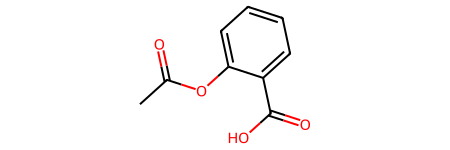

In [5]:
# convert to networkx graph
graph_from_mol = smiles_to_graph(smiles)
# convert back to rdkit mol
mol_from_graph = graph_to_smiles(graph_from_mol)
print(Chem.MolToSmiles(mol_from_graph))
mol_from_graph

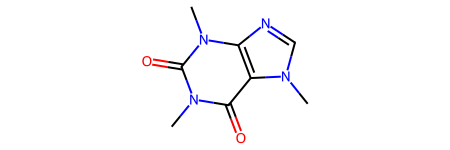

In [6]:
# example - 2
smiles = 'Cn1cnc2c1c(=O)n(C)c(=O)n2C'
mol = Chem.MolFromSmiles(smiles)
mol

Cn1c(=O)c2c(ncn2C)n(C)c1=O


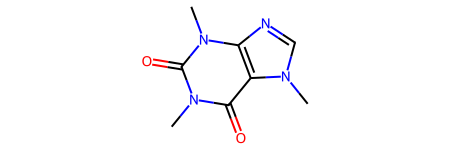

In [7]:
# convert to networkx graph
graph_from_mol = smiles_to_graph(smiles)
# convert back to rdkit mol
mol_from_graph = graph_to_smiles(graph_from_mol, write_smiles=False)
print(Chem.MolToSmiles(mol_from_graph))
mol_from_graph

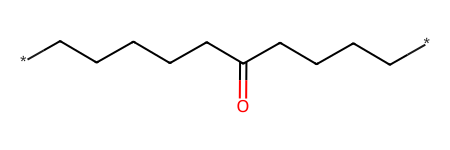

In [8]:
# example - 3
smiles = '[*]CCCCCC(=O)CCCC[*]'
mol = Chem.MolFromSmiles(smiles)
mol

*CCCCCC(=O)CCCC*


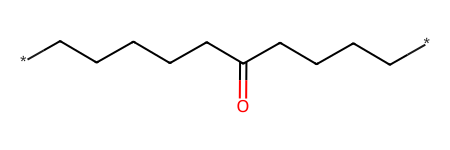

In [9]:
# convert to networkx graph
graph_from_mol = smiles_to_graph(smiles)
# convert back to rdkit mol
mol_from_graph = graph_to_smiles(graph_from_mol, write_smiles=False)
print(Chem.MolToSmiles(mol_from_graph))
mol_from_graph

# Create Graph

Given a smiles data with rows of SMILES and property only

In [10]:
import sys
sys.path.append('../')

In [12]:
from src.createGraph import graph_dataset
import pandas as pd

In [13]:
data_path = '../data/test.csv'
data = pd.read_csv(data_path, names=['smiles', 'label'])
data.head()

,smiles,label
0,CCCCCCCCC(O)CO,3.361728
1,CCCCCCCCC(O)CCO,3.361728
2,CCCCCCCCCCCCC(O)CCO,1.113943
3,CCCCCCCCOCCO,3.690196
4,CCCCCCCCOCCOCCOCCO,3.875061


In [14]:
smiles = data['smiles'].values
y = data['label'].values

In [15]:
dataset = graph_dataset(smiles,y)

In [16]:
dataset[0][0]

# Create GNN

In [17]:
import sys
sys.path.append('../')

In [18]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler

from src.load_csv import read_data
from src.createGraph import graph_dataset

In [19]:
data_path = '../data/test.csv'

[train_ind, test_ind, smlstr_train, smlstr_test, 
                            prop_train, prop_test] = read_data(csv_path=data_path, seed=2023, 
                                                                test_size=0.2, randSplit=True, write_out_files=False)

Using Random Splits
Train/Test split complete. See ../data/ for output files (if desired).


In [20]:
train_full_dataset = graph_dataset(smlstr_train,prop_train)
test_dataset = graph_dataset(smlstr_test,prop_test)

In [21]:
train_full_dataset[0][0].nodes(data=True)

NodeDataView({0: {'atomic_num': 6, 'formal_charge': 0, 'chiral_tag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3, 'num_explicit_hs': 0, 'is_aromatic': False}, 1: {'atomic_num': 6, 'formal_charge': 0, 'chiral_tag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3, 'num_explicit_hs': 0, 'is_aromatic': False}, 2: {'atomic_num': 6, 'formal_charge': 0, 'chiral_tag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3, 'num_explicit_hs': 0, 'is_aromatic': False}, 3: {'atomic_num': 6, 'formal_charge': 0, 'chiral_tag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3, 'num_explicit_hs': 0, 'is_aromatic': False}, 4: {'atomic_num': 6, 'formal_charge': 0, 'chiral_tag': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 'hybridization': rdkit.Chem.rdchem.HybridizationType.SP3, 'num_explic

In [22]:
train_sampler = SubsetRandomSampler(train_ind)
train_loader = torch.utils.data.DataLoader(train_full_dataset, batch_size=32,
                                                       sampler=train_sampler,
                                                       shuffle=False)

In [23]:
train_sampler.indices

array([ 80, 114,  50,  60,   4, 102,  74,  97,  24,  99, 105,   8,   2,
       117,  26, 113,  94,  62,  18,  21,  66,  36, 106,  37,  56,  14,
        46,  68, 100,  35, 112,   6,  84, 118,  67,  79,  10,   5,  57,
        43, 104,  40,  19,  51,  31,   1,  11,  73,  76,  78,  90,  34,
       120,  45,   7,  89, 110,  98,  65, 107,  72,  15, 119,  38, 108,
        91, 116,  93,  49,  29,  32,  48,  63,  71,  81,  28,  58, 115,
        88,  69,  39,  77,  47,  53,  17,  22,  96, 101,  86,  52,   3,
        92,  33,  55,  70,  25,  87])

In [28]:
train_loader

In [29]:
# for i, (graph, label) in enumerate(train_loader):
#     print(i, graph, label)
for data in train_loader:
    batched_graph = data[0] 
    labels = data[1]

IndexError: list index out of range

In [24]:
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn
from torch_geometric.data import Data, DataLoader

# Convert the graph to a PyTorch Geometric data object
def convert_to_torch_geo_data(graph, label):
    node_features = []
    edge_indices, edge_features = [], []

    for _, node_data in graph.nodes(data=True):
        node_features.append([
            node_data['atomic_num'],
            node_data['formal_charge'],
            node_data['chiral_tag'],
            node_data['hybridization'],
            node_data['num_explicit_hs'],
            node_data['is_aromatic']
        ])

    for start, end, edge_data in graph.edges(data=True):
        edge_indices.append([start, end])
        bond_type = edge_data['bond_type']
        edge_features.append([
            bond_type.is_single(),
            bond_type.is_double(),
            bond_type.is_triple(),
            bond_type.is_aromatic()
        ])

    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_features = torch.tensor(edge_features, dtype=torch.float)
    label = torch.tensor([label], dtype=torch.float)
    
    return Data(x=node_features, edge_index=edge_indices, edge_attr=edge_features, y=label)

class GNNLayer(geom_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GNNLayer, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels * 2, out_channels)
        
    def forward(self, x, edge_index, edge_attr):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_attr=edge_attr)
        
    def message(self, x_i, x_j, edge_attr):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]
        # edge_attr has shape [E, edge_features]

        # Concatenate node features and edge features
        msg = torch.cat([x_i, x_j, edge_attr], dim=1)  
        return self.lin(msg)

class SimpleGNN(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels):
        super(SimpleGNN, self).__init__()
        self.conv1 = GNNLayer(node_in_channels + edge_in_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(x)
        x = geom_nn.global_add_pool(x, data.batch)
        x = self.lin(x)
        
        return x

# Model
model = SimpleGNN(6, 4, 64, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for batch in train_loader:
    graphs, labels = batch
    data_list = [convert_to_torch_geo_data(g, l.item()) for g, l in zip(graphs, labels)]
    batch_data = DataLoader(data_list, batch_size=32, shuffle=False)
    
    for data in batch_data:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()


IndexError: list index out of range

In [31]:
import torch_geometric

OSError: dlopen(/Users/gbemidebe/miniconda3/envs/MatML/lib/python3.8/site-packages/torch_sparse/_diag_cpu.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <F8C3A229-1B75-3524-8D9B-681CF119F564> /Users/gbemidebe/miniconda3/envs/MatML/lib/python3.8/site-packages/torch_sparse/_diag_cpu.so
  Expected in:     <1E9FA061-EA31-3736-81D0-79A33B965097> /Users/gbemidebe/miniconda3/envs/MatML/lib/python3.8/site-packages/torch/lib/libc10.dylib